This notebook explores s-process exposures.

This section checks if you have the required python packages installed. If you do have them installed, it will simply skip this step, if not, it will install them for you within the notebook's container

In [1]:
import sys, subprocess,pkg_resources
required = {'numpy','wnutils','matplotlib','ipython'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])
    #!{sys.executable} -m pip install --quiet wnutils
    #!{sys.executable} -m pip install --quiet numpy
    #!{sys.executable} -m pip install --quiet matplotlib

The next step is to import the package to check for and retrieve the data:

This notebook uses [wnutils](https://wnutils.readthedocs.io) to analyze the nucleosyntheis [XML](https://www.w3.org/TR/REC-xml/) output, so we import that package.

In [2]:
import wnutils.xml as wx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

The next step is the read in the data from the various calculations.

In [3]:
sproc = wx.Xml('sproc.xml')

Helium burning creates a carbon/oxygen core in the star.  If the core becomes [degenerate](https://en.wikipedia.org/wiki/Degenerate_matter#Degenerate_gases) at this stage, it is able to sustain itself against further gravitational contraction without further nuclear burning.  The reason is that radiation loss normally leads to a loss of energy from the core, which means the pressure decreases.  Nuclear burning releases energy and maintains the necessary pressure.  For degenerate matter, however, the pressure is simply maintained by the fact that no two electrons can exist in the same quantum mechanical state (the [Pauli exclusion principle](https://en.wikipedia.org/wiki/Pauli_exclusion_principle).  At high density, this fact allows there to be strong pressure even at low temperature.

Outside the carbon/oxygen core, helium-rich matter exists and can undergo helium burning.  The ashes of this burning ($^{12}$C and $^{16}$O) settle onto the core and increase the core's mass.  The burning is in fact a complicated and alternating interplay of shell helium burning and shell hydrogen burning outside the helium burning, with mixing occurring between the various shell burnings.  This is the burning that occurs during the star's life on the [asymptotic giant branch](https://en.wikipedia.org/wiki/Asymptotic_giant_branch).  During this phase, [s-processing](https://en.wikipedia.org/wiki/S-process) can occur.

The present calculation modeled s-process nucleosynthesis by running the ashes of helium burning at constant temperature, density, and neutron density, which are printed in the next cell.

In [4]:
props = sproc.get_properties_as_floats(['time','t9', 'rho'])
x_n = sproc.get_mass_fractions(['n'])['n']
n_n = x_n[len(x_n)-1] * props['rho'][len(props['rho'])-1] * 6.022e23
print('For the calculation, the duration, temperature, mass density, and neutron density were:')
print('   time (yr) = {0:.2e}'.format(props['time'][len(props['time'])-1] / 3.15e7))
print('   T (K) = {:.2e}'.format(props['t9'][len(props['t9'])-1] * 1.e9))
print('   mass density (g/cc) = {:.2e}'.format(props['rho'][len(props['rho'])-1]))
print('   neutron density (per cc) = {:.2e}'.format(n_n))

For the calculation, the duration, temperature, mass density, and neutron density were:
   time (yr) = 1.00e+05
   T (K) = 2.50e+08
   mass density (g/cc) = 1.00e+03
   neutron density (per cc) = 1.00e+08


The neutron exposure grows with time.

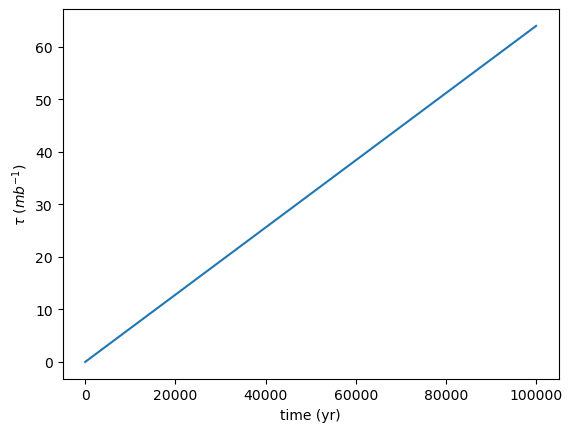

In [5]:
sproc.plot_property_vs_property('time', ('exposure','n'), xfactor = 3.15e7, xlabel='time (yr)', ylabel='$\\tau\ (mb^{-1})$')

View the abundances versus mass number for several exposures (chosen by XPath).

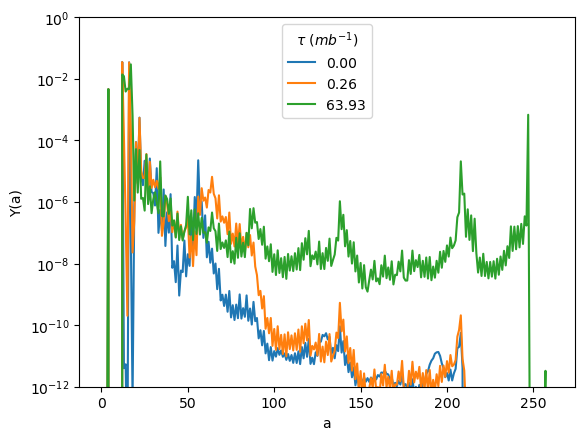

In [6]:
my_zone_xpath = '[(position() = 1) or (position() = 110) or (position() = last())]'
zone_data = sproc.get_zone_data(my_zone_xpath)
tau1 = ["{:.2f}".format(float(zone1['properties'][('exposure', 'n')])) for zone1 in zone_data.values()]
sproc.plot_abundances_vs_nucleon_number(zone_xpath=my_zone_xpath, yscale = 'log', ylim = [1.e-12,1], legend=(tau1, {'title': '$\\tau\ (mb^{-1}$)'}))

View an animation that shows the variation of the abundances as function of mass number as time & exposure move forward

In [7]:

fig = plt.figure()
my_zone_xpath_init='[(position()=1)]'
zone_data_init = sproc.get_zone_data(my_zone_xpath_init)
y_init = sproc.get_abundances_vs_nucleon_number(nucleon='a',zone_xpath = my_zone_xpath_init)

def animate(i):
    fig.clear()
    my_zone_xpath = '[(position() = '+str(i)+')]'
    zone_data = sproc.get_zone_data(my_zone_xpath)
    tau = ["{:.2f}".format(float(zone['properties'][('exposure', 'n')])) for zone in zone_data.values()]
    y = sproc.get_abundances_vs_nucleon_number(nucleon='a', zone_xpath=my_zone_xpath)
    for k in range(y.shape[0]):
        plt.plot(y[k, :],label = 'Abundances @ time (yr) = {0:.2e}'.format(props['time'][i] / 3.15e7))
    for k1 in range(y_init.shape[0]):
        plt.plot(y_init[k1,:],'-.',color='grey',label='Initial Abundances')
    plt.ylim([1.e-12,1])
    plt.xlim([0,250])
    plt.yscale('log')
    plt.ylabel('Y(A)')
    plt.xlabel('A')
    plt.legend(loc='upper right')
    plt.title(r'$\tau(mb^{-1})$ = '+str(tau))
    
    
anim = animation.FuncAnimation(fig,animate,len(props['time']))  
HTML(anim.to_html5_video())

Average over exposures.  This could be much better: split up.  Change tau_0 for different averages.

In [8]:
plt.clf()
tau_0 = 10
props = sproc.get_properties_as_floats([('exposure', 'n')])
nucs = sproc.get_nuclide_data()
y = sproc.get_all_abundances_in_zones()

# Create an array of dtaus.

dtau = np.diff(props[('exposure','n')])

# Initialize average sum and array.

w = 0
y_sum = np.zeros((y.shape[1], y.shape[2]))
ya_sum = np.zeros(y.shape[1] + y.shape[2])


# Do integration.  This really could be done more pythonically.

for i in range(y.shape[0]):
    factor = dtau[i-1] * np.exp(-props[('exposure','n')][i] / tau_0) / tau_0
    w += factor
    for z in range(y.shape[1]):
        for n in range(y.shape[2]):
            y_sum[z,n] += y[i,z,n] * factor
            ya_sum[z+n] += y[i,z,n] * factor

y_sum /= w
ya_sum /= w

Plot abundances averaged over exposures.

<Figure size 640x480 with 0 Axes>

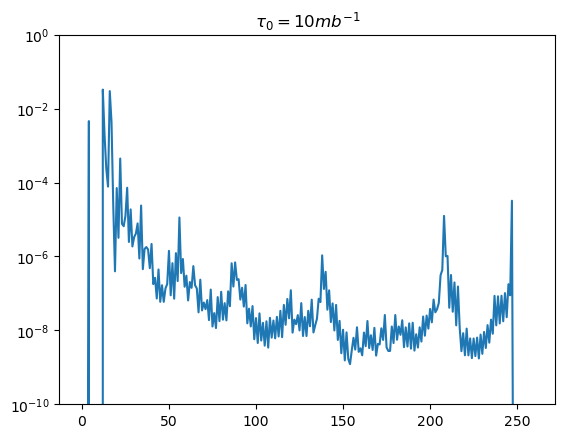

In [9]:
plt.figure()
plt.plot(ya_sum)
plt.yscale('log')
plt.ylim([1.e-10,1])
plt.title(r'$\tau_{0} =$' + str(tau_0) + ' $mb^{-1}$')
plt.show()